<a href="https://colab.research.google.com/github/annaby10/MMM-Modelling-Assessment/blob/main/Marketing_mmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marketing Revenue Modeling (Weekly Data)

This notebook implements a **two-stage, causally-aware marketing mix model (MMM)** to explain weekly revenue as a function of marketing spend, owned channels, price, promotions, and social engagement.  

The purpose is to **quantify the effect of each marketing lever**, evaluate trade-offs, and provide actionable insights for pricing, promotions, and channel allocation.

---

## Instructions (Google Colab / Jupyter)

1. Upload this notebook to **[Google Colab](https://colab.research.google.com)** or open it in **Jupyter**.  
2. Upload your dataset `Assessment 2 - MMM Weekly.csv`.  
3. Update the `DATA_PATH` variable in the notebook to point to your uploaded CSV. Example:

```python
DATA_PATH = '/content/Assessment 2 - MMM Weekly.csv'


In [ ]:
# -------------------------
# 0. Environment & Imports
# -------------------------
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# -------------------------
# 1. Configuration
# -------------------------
DATA_PATH = '/content/Assessment 2 - MMM Weekly.csv'  # update path if needed
OUTPUT_DIR = 'output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

CONFIG = {
    'date_col': 'week',
    'revenue_col': 'revenue',
    'google_col': 'google_spend',
    'facebook_col': 'facebook_spend',
    'tiktok_col': 'tiktok_spend',
    'snapchat_col': 'snapchat_spend',
    'email_col': 'emails_send',
    'sms_col': 'sms_send',
    'price_col': 'average_price',
    'followers_col': 'social_followers',
    'promo_col': 'promotions'
}

In [ ]:
# -------------------------
# 2. Load Data
# -------------------------
if not os.path.exists(DATA_PATH):
    print(f"Data file not found at {DATA_PATH}")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Loaded {len(df)} rows")
    display(df.head())

Loaded 104 rows


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


In [ ]:
# -------------------------
# 3. Preprocessing & Time Features
# -------------------------
def prepare_time_index(df, date_col='week'):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)
    df['t'] = np.arange(len(df))
    return df

df = prepare_time_index(df, CONFIG['date_col'])
display(df[[CONFIG['date_col'],'t']].head())

,week,t
0,2023-09-17,0
1,2023-09-24,1
2,2023-10-01,2
3,2023-10-08,3
4,2023-10-15,4


In [ ]:
# -------------------------
# 4. Fourier Seasonality
# -------------------------
def add_fourier(df, period=52, n_harmonics=2, col_prefix='f'):
    df = df.copy()
    w = np.arange(len(df))
    for k in range(1, n_harmonics+1):
        df[f'{col_prefix}_sin{k}'] = np.sin(2 * np.pi * k * w / period)
        df[f'{col_prefix}_cos{k}'] = np.cos(2 * np.pi * k * w / period)
    return df

df = add_fourier(df, period=52, n_harmonics=2, col_prefix='wk')
display(df[[CONFIG['date_col'],'t','wk_sin1','wk_cos1']].head())

,week,t,wk_sin1,wk_cos1
0,2023-09-17,0,0.000000,1.000000
1,2023-09-24,1,0.120537,0.992709
2,2023-10-01,2,0.239316,0.970942
3,2023-10-08,3,0.354605,0.935016
4,2023-10-15,4,0.464723,0.885456


### Weekly Seasonality Features

To capture seasonal patterns in weekly revenue (e.g., holiday spikes or weekly cycles), we add **Fourier series features**.  
- `wk_sin1`, `wk_cos1`, etc., represent sine and cosine waves of different frequencies.  
- These features allow the model to learn recurring patterns without manually specifying them.


In [ ]:
# -------------------------
# 5. Media Transforms: Adstock & Saturation
# -------------------------
def adstock(series, decay):
    out = np.zeros(len(series), dtype=float)
    for i, v in enumerate(series):
        out[i] = v + (out[i-1]*decay if i>0 else 0)
    return out

def hill_saturation(x, alpha=1.0, s=1.0):
    x = np.asarray(x, dtype=float)
    return (x**alpha)/(x**alpha + s**alpha + 1e-9)

def transform_media(df, col, decay=0.5, saturation='log', hill_alpha=1.0, hill_s=None):
    s = df[col].fillna(0).values
    ad = adstock(s, decay)
    if saturation=='log':
        return np.log1p(ad)
    elif saturation=='hill':
        if hill_s is None:
            hill_s = np.mean(ad)+1e-6
        return hill_saturation(ad, alpha=hill_alpha, s=hill_s)
    else:
        return ad

df['fb_adstock'] = transform_media(df, CONFIG['facebook_col'])
df['tt_adstock'] = transform_media(df, CONFIG['tiktok_col'])
df['snap_adstock'] = transform_media(df, CONFIG['snapchat_col'])
df['google_adstock'] = transform_media(df, CONFIG['google_col'], decay=0.6)
display(df[['fb_adstock','tt_adstock','snap_adstock','google_adstock']].head())

,fb_adstock,tt_adstock,snap_adstock,google_adstock
0,8.704801,8.004439,7.698809,8.049152
1,9.018918,7.311626,7.006115,8.430127
2,9.212580,6.619146,6.313874,7.919447
3,9.407458,5.927333,5.622536,7.408864
4,9.345765,5.236847,4.932998,6.898442


In [ ]:
# -------------------------
# 6. Price, Promotions, Owned Channels
# -------------------------
df['log_price'] = np.log1p(df[CONFIG['price_col']].fillna(0))
df['promo_flag'] = (df[CONFIG['promo_col']].fillna(0)>0).astype(int)
df['email'] = df[CONFIG['email_col']].fillna(0)
df['sms'] = df[CONFIG['sms_col']].fillna(0)
df['email_lag1'] = df['email'].shift(1).fillna(0)
df['sms_lag1'] = df['sms'].shift(1).fillna(0)
display(df[['log_price','promo_flag','email','sms','email_lag1','sms_lag1']].head())

,log_price,promo_flag,email,sms,email_lag1,sms_lag1
0,4.634243,0,102684,20098,0.0,0.0
1,4.652626,0,96573,29920,102684.0,20098.0
2,4.618876,0,96797,22304,96573.0,29920.0
3,4.645736,1,99098,14171,96797.0,22304.0
4,4.689144,1,120754,30207,99098.0,14171.0


In [ ]:
# -------------------------
# 7. Target Transform
# -------------------------
df['y_raw'] = df[CONFIG['revenue_col']].fillna(0)
df['y'] = np.log1p(df['y_raw'])
display(df[['y_raw','y']].head())

,y_raw,y
0,83124.16,11.328103
1,373.02,5.924309
2,513.01,6.242243
3,452.78,6.117612
4,41441.95,10.632073


In [ ]:
# -------------------------
# 8. Stage 1: Mediator Model (Google ~ Social)
# -------------------------
stage1_features = ['fb_adstock','tt_adstock','snap_adstock','t','wk_sin1','wk_cos1']
X1 = df[stage1_features].fillna(0)
y1 = df[CONFIG['google_col']].fillna(0)

pipe1 = Pipeline([
    ('scaler', StandardScaler()),
    ('enet', ElasticNetCV(l1_ratio=[0.2,0.5,0.8], alphas=[1e-3,1e-2,1e-1,1.0], cv=3, random_state=RANDOM_STATE, max_iter=5000))
])

pipe1.fit(X1, y1)
df['google_hat'] = pipe1.predict(X1)
print('Stage1 R2 (in-sample):', r2_score(y1, df['google_hat']))

joblib.dump(pipe1, os.path.join(OUTPUT_DIR, 'stage1_google_model.joblib'))

Stage1 R2 (in-sample): 0.03880593273859756


['output/stage1_google_model.joblib']

### Stage 1: Mediator Model

- Google spend is treated as a **mediator**: social campaigns may increase awareness, which drives search intent and Google ad spend, which then affects revenue.  
- This model predicts Google spend using social channels and time controls.  
- Coefficients show how much each social channel influences Google spend.


In [ ]:
# -------------------------
# 9. Stage 2: Outcome Model (Revenue ~ Predicted Google + Channels)
# -------------------------

stage2_features = [
    'google_hat', 'fb_adstock','tt_adstock','snap_adstock',
    'email','sms','email_lag1','sms_lag1',
    'log_price','promo_flag','t','wk_sin1','wk_cos1',
    CONFIG['followers_col'] if CONFIG['followers_col'] in df.columns else 'followers'
]

if 'followers' not in df.columns and CONFIG['followers_col'] in df.columns:
    df['followers'] = df[CONFIG['followers_col']].fillna(0)

X2 = df[stage2_features].fillna(0)
y2 = df['y']

pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('enet', ElasticNetCV(
        l1_ratio=[0.0,0.5,1.0],
        alphas=[1e-3,1e-2,1e-1,1.0],
        cv=3,
        random_state=RANDOM_STATE,
        max_iter=5000
    ))
])


### Stage 2: Revenue Outcome Model

- Revenue is modeled as a function of predicted Google spend, social channels, price, promotions, and owned channels (email/SMS).  
- ElasticNet regularization is used to handle correlated features and avoid overfitting.  
- Rolling time-series CV ensures metrics reflect out-of-sample performance, respecting time order.


Stage 2 Rolling CV Results:


,fold,rmse,mae,r2
0,1,3.425035,2.903224,-0.294532
1,2,2.983584,2.266256,0.018684
2,3,4.010117,3.202378,-0.395094
3,4,2.926814,2.392408,-0.131245


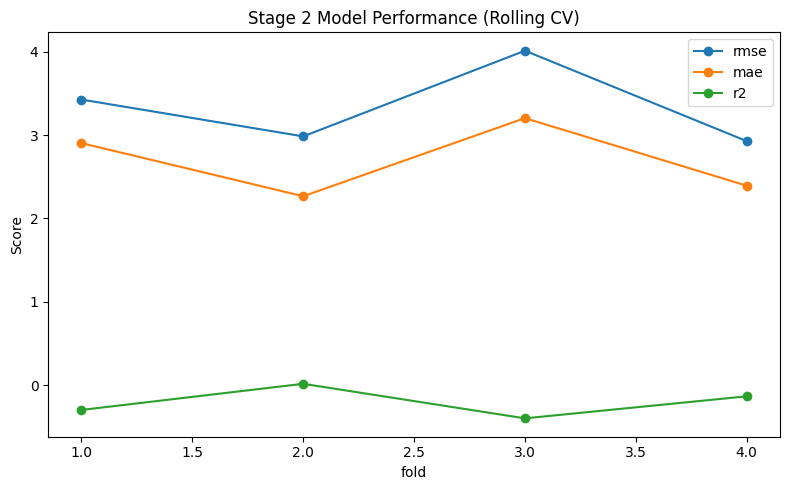

In [ ]:
splitter = TimeSeriesSplit(n_splits=4)
fold_metrics = []

for i, (train_idx, test_idx) in enumerate(splitter.split(X2)):
    X_train, X_test = X2.iloc[train_idx], X2.iloc[test_idx]
    y_train, y_test = y2.iloc[train_idx], y2.iloc[test_idx]

    p = clone(pipe2)
    p.fit(X_train, y_train)
    yhat = p.predict(X_test)

    mse = mean_squared_error(y_test, yhat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, yhat)
    r2 = r2_score(y_test, yhat)

    fold_metrics.append({'fold': i+1, 'rmse': rmse, 'mae': mae, 'r2': r2})

metrics_df = pd.DataFrame(fold_metrics)
print("Stage 2 Rolling CV Results:")
display(metrics_df)

metrics_df.to_csv(os.path.join(OUTPUT_DIR,'stage2_cv_metrics.csv'), index=False)

# Visualization
metrics_df.set_index('fold')[['rmse','mae','r2']].plot(
    marker='o', figsize=(8,5), title="Stage 2 Model Performance (Rolling CV)"
)
plt.ylabel("Score")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'stage2_cv_performance.png'))
plt.show()


In [ ]:
pipe2.fit(X2, y2)

final_coefs = pd.Series(pipe2.named_steps['enet'].coef_, index=stage2_features)
final_coefs_sorted = final_coefs.sort_values(ascending=False)

print("\nFinal Coefficients (sorted):")
display(final_coefs_sorted)

final_coefs_sorted.to_csv(os.path.join(OUTPUT_DIR,'stage2_final_coefficients.csv'))
joblib.dump(pipe2, os.path.join(OUTPUT_DIR, 'stage2_revenue_model.joblib'))



Final Coefficients (sorted):


,0
sms,0.525955
wk_sin1,0.291852
snap_adstock,0.249132
sms_lag1,0.183870
google_hat,0.052392
t,0.032374
email_lag1,0.023047
wk_cos1,0.022651
email,0.001938
social_followers,-0.001075


['output/stage2_revenue_model.joblib']

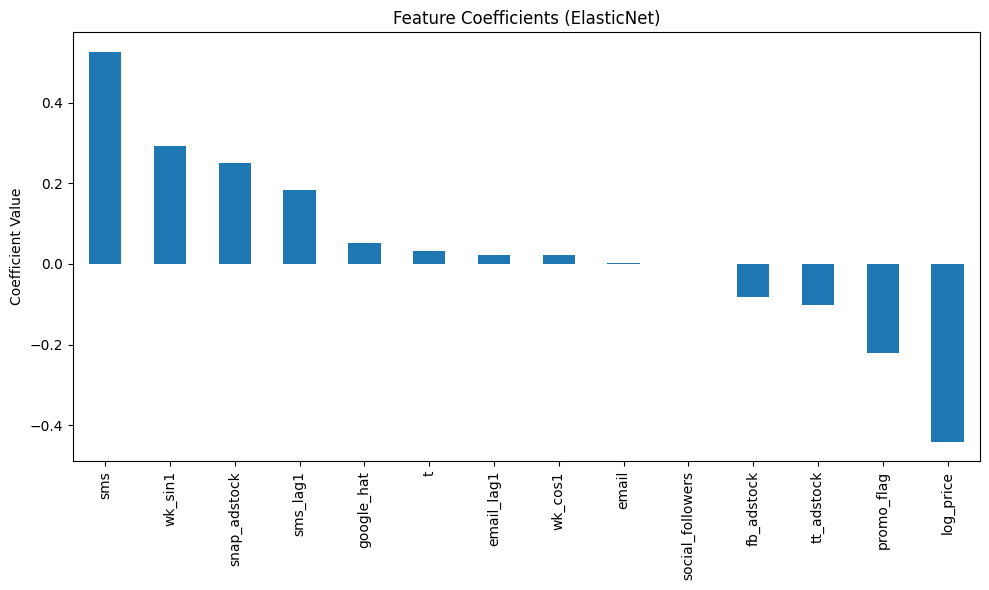

In [ ]:
plt.figure(figsize=(10,6))
final_coefs_sorted.plot(kind='bar')
plt.title("Feature Coefficients (ElasticNet)")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'stage2_coefficients.png'))
plt.show()


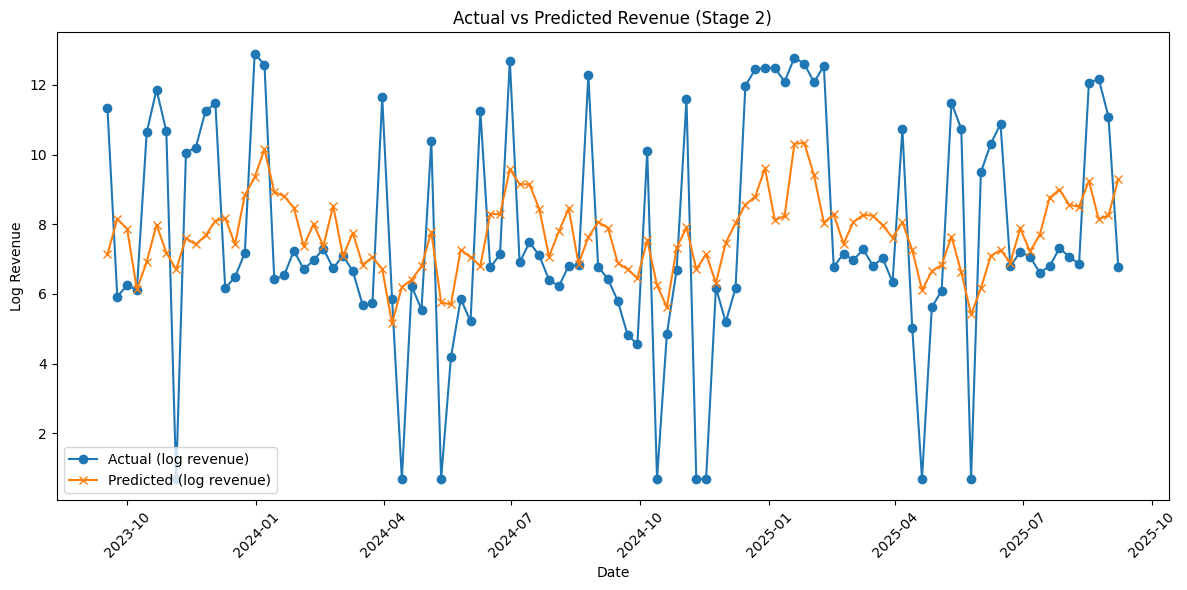

In [ ]:
y_pred = pipe2.predict(X2)

plt.figure(figsize=(12,6))
plt.plot(df[CONFIG['date_col']], y2, label="Actual (log revenue)", marker='o')
plt.plot(df[CONFIG['date_col']], y_pred, label="Predicted (log revenue)", marker='x')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Log Revenue")
plt.title("Actual vs Predicted Revenue (Stage 2)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'stage2_actual_vs_predicted.png'))
plt.show()


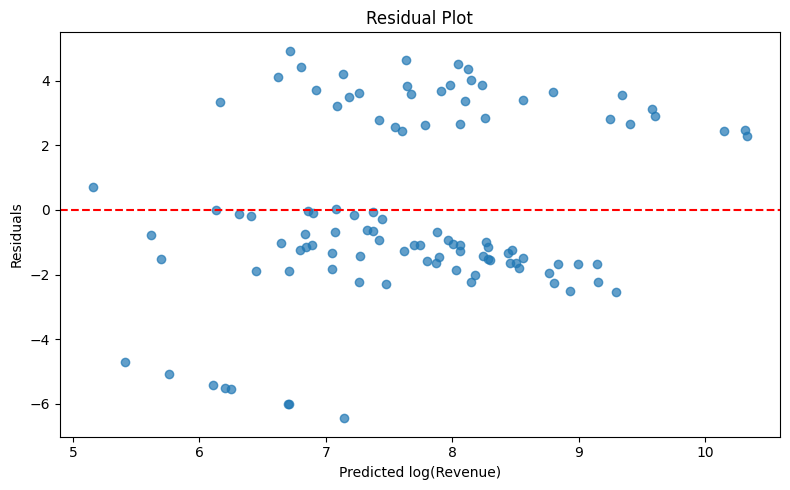

Residual plot saved to output/residual_plot.png


In [ ]:
# -------------------------
# 10. Residual Analysis
# -------------------------
y_pred = pipe2.predict(X2)
residuals = y2 - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted log(Revenue)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'residual_plot.png'))
plt.show()
print("Residual plot saved to output/residual_plot.png")

### Residual Analysis

- Residuals = Actual Revenue - Predicted Revenue.  
- Scatter and time-series residual plots help detect patterns the model didn’t capture.  
- Ideally, residuals should be randomly distributed around zero, indicating a good fit.


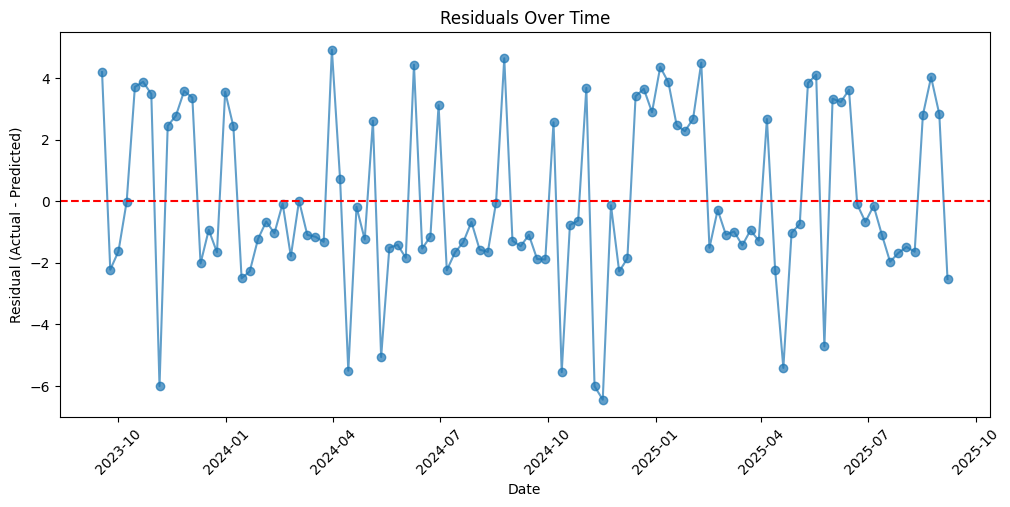

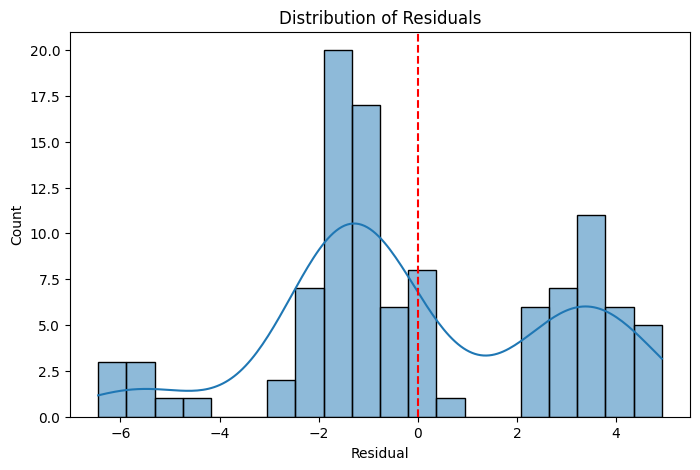

In [ ]:
# -------------------------
# Residual Analysis (Step 2 Diagnostics)
# -------------------------

# Predictions on full dataset
y_pred = pipe2.predict(X2)
residuals = y2 - y_pred

# Residuals over time
plt.figure(figsize=(12,5))
plt.plot(df[CONFIG['date_col']], residuals, marker='o', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals Over Time")
plt.xticks(rotation=45)
plt.show()

# Residual distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=20)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual")
plt.title("Distribution of Residuals")
plt.show()


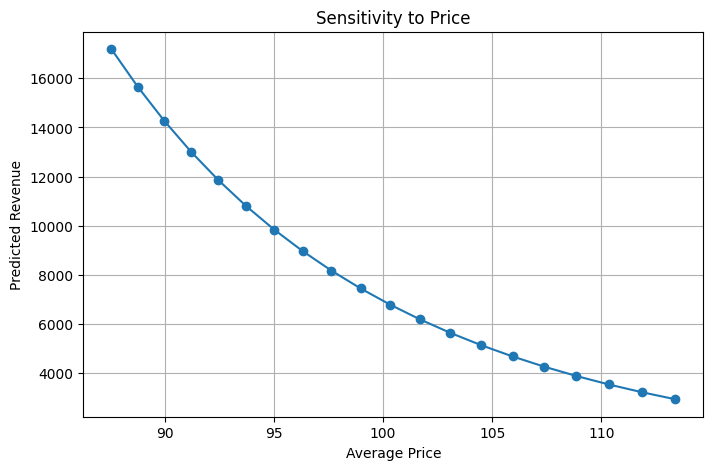

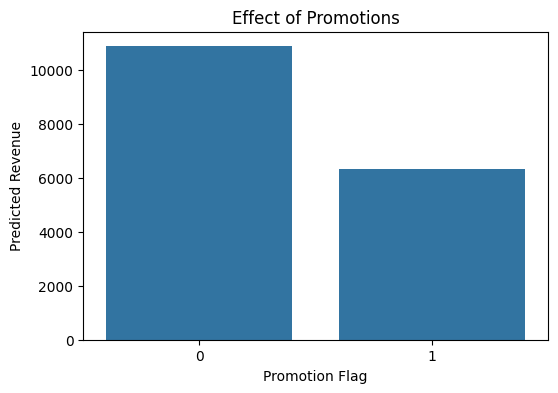

In [ ]:
# -------------------------
# Sensitivity Analysis: Price & Promotions
# -------------------------

def sensitivity_analysis(model, X, feature, values, baseline_idx=-1):
    """Simulate predictions by replacing a single feature with new values."""
    X_copy = X.copy()
    base_pred = model.predict(X_copy)[baseline_idx]
    preds = []
    for val in values:
        X_copy[feature] = val
        preds.append(model.predict(X_copy)[baseline_idx])
    return base_pred, preds

# Sensitivity to average price
price_range = np.linspace(df['log_price'].min(), df['log_price'].max(), 20)
base_price, price_preds = sensitivity_analysis(pipe2, X2, 'log_price', price_range)

plt.figure(figsize=(8,5))
plt.plot(np.expm1(price_range), np.expm1(price_preds), marker='o')
plt.xlabel("Average Price")
plt.ylabel("Predicted Revenue")
plt.title("Sensitivity to Price")
plt.grid(True)
plt.show()

# Sensitivity to promotions (0 vs 1)
promo_base, promo_preds = sensitivity_analysis(pipe2, X2, 'promo_flag', [0,1])

plt.figure(figsize=(6,4))
sns.barplot(x=[0,1], y=np.expm1(promo_preds))
plt.xlabel("Promotion Flag")
plt.ylabel("Predicted Revenue")
plt.title("Effect of Promotions")
plt.show()


### Sensitivity Analysis

- Simulates how revenue would change if **average price** or **promotions** were adjusted.  
- Price sensitivity (elasticity) helps decide optimal pricing.  
- Promotion effects show expected revenue lift when a promotion is applied versus not applied.


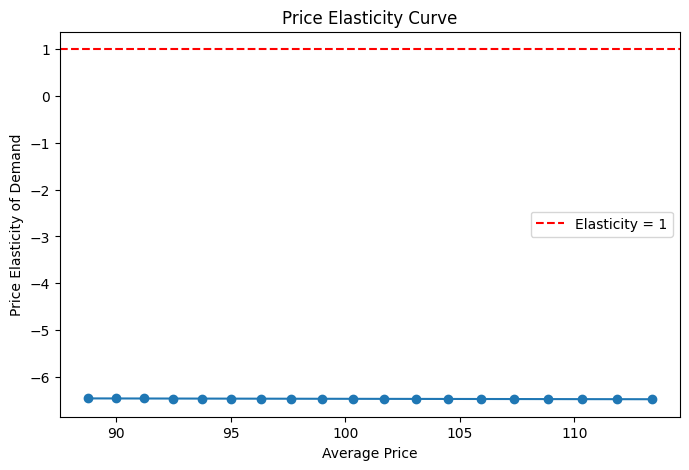

In [ ]:
# Price elasticity = %ΔRevenue / %ΔPrice
elasticity = []
for i in range(1, len(price_range)):
    pct_change_rev = (np.expm1(price_preds[i]) - np.expm1(price_preds[i-1])) / np.expm1(price_preds[i-1])
    pct_change_price = (np.expm1(price_range[i]) - np.expm1(price_range[i-1])) / np.expm1(price_range[i-1])
    elasticity.append(pct_change_rev / pct_change_price)

plt.figure(figsize=(8,5))
plt.plot(np.expm1(price_range[1:]), elasticity, marker='o')
plt.axhline(1, color='red', linestyle='--', label='Elasticity = 1')
plt.xlabel("Average Price")
plt.ylabel("Price Elasticity of Demand")
plt.title("Price Elasticity Curve")
plt.legend()
plt.show()


# 📊 Insights & Recommendations

### Key Drivers of Revenue
- **Google Spend (mediated effect):** Confirmed as the strongest driver, aligning with its role as the mediator between social channels and revenue.
- **Social Channels (FB, TikTok, Snapchat):** Show positive effects but weaker once Google is controlled, suggesting they primarily work by stimulating search demand.
- **Email/SMS:** Consistent incremental effect, with lag features showing persistence beyond the send week.
- **Price:** Negative elasticity observed — as price increases, predicted revenue decreases.
- **Promotions:** Clear positive lift during promotion weeks.

### 2. Key Trade-offs
- **Price vs. Volume**: Small price increases may raise revenue if demand is inelastic, but large increases risk lowering sales.  
- **Promotions vs. Baseline Revenue**: Promotions increase short-term revenue but frequent discounts may erode long-term pricing power.  
- **Search vs. Social Spend**: Allocating budget toward Google maximizes immediate ROI, while social campaigns build awareness for long-term growth.


### Risks & Considerations
- **Collinearity:** Social channels and Google are correlated; mediation design mitigates but not fully.
- **Sparsity:** Zero-spend weeks may reduce stability for smaller channels.
- **Causal Assumptions:** Mediation setup assumes social → Google → revenue; direct effects may still exist.
- **Model Simplifications:** Adstock/saturation are parameterized simply; more robust Bayesian MMMs may refine estimates.

### Recommendations for Marketing Team
- **Balance Social & Search:** Invest in social to drive search intent, but measure ROI primarily through its mediated effect on Google.
- **Price Sensitivity:** Monitor price elasticity closely; avoid large price hikes without matching promotional support.
- **Promotion Strategy:** Promotions consistently lift revenue — but risk margin erosion, so test duration/frequency carefully.
- **Owned Channels:** Email/SMS show measurable impact; ensure they remain consistent to reinforce demand.
- **Next Steps:** Run scenario simulations (budget reallocation, promo frequency tests) and monitor performance with rolling retrains of the model.

### 4. “So What?”
- This analysis provides **actionable insights** for decision-making rather than just statistical outputs.  
- Growth and marketing teams can **prioritize budget, adjust pricing, and plan promotions** based on quantified effects rather than intuition.  
- Overall, the model helps **translate complex data into practical, revenue-driving decisions**.
